# Spectral Clustering
written by Eric Bridgeford and Theodor Marinov

In this notebook, we will investigate the Spectral clustering implementation provided for our course project.

## Algorithm Basics

The algorithm used here is Spectral clustering as implemented in the Andrew Ng paper.

### Spectral Cluster Ng

Given: $X = \begin{bmatrix} x_1 & \ldots & x_n\end{bmatrix}$, $K(x, y)$ a kernel function

1. $A_{ij} = K(x_i, x_j)$
2. $D = A.sum(columnwise)I$, a diagonal matrix whose entries are the columnwise sums of $A$
3. $L = D^{\frac{1}{2}}AD^{\frac{1}{2}}$
4. $(U, S, V^*) = SVD(L)$
5. $U_k = U[:, 0:k]$, the top $k$ left singular vectors
6. $Y_i = U_{k, i}/||U_{k, i}||$, the normalized left singular vectors
7. Cluster $Y$ using K-means clustering

Here, we will concern ourselves with the RBF kernel. The RBF kernel looks for radially symmetric clusters; that is, it looks for clusters that have a notion of appearing in circular patterns, where the radius of the "circle" it will identify can be tuned with the sigma of the RBF. We know that the RBF kernel is defined:

\begin{align*}
    K(x_i, x_j | \sigma) = e^{-\frac{||x_i - x_j||}{2 \sigma^2}}
\end{align*}

which defines an analogue to an inner product in our "spectral domain", or the innate domain on which our points lie. From a logical perspective, if we think about the shape of a Gaussian (the same as an RBF), what is really happening here is that we are forming our spectral domain by looking at how significantly points differ when they are projected to the surface of our Gaussian. We can see immediately that as $\sigma$ decreases, we are going to significantly amplify the differences we find in our spectral domain between points that might be spatially close, but at a different "level set" in our gaussian; that is, we are "narrowing" the peak of our Gaussian, and hence making it much higher in the process (thereby separating our points more). Then when we think about our data, points that are radially symmetric in some way will appear on the same "level set" of the gaussian. When we perform $K-$means in the spectral domain, we essentially perform component analysis on our data projected onto this gaussian, and retain the components that give us the maximal separation in this new domain. 

On the other hand, we we increase $\sigma$, our kernel will start to look more similar given differing $x_i, x_j$, and when we consider the relative weighting of all of our points, higher $\sigma$ will basically widen our Gaussian and give us a flatter and flatter "innate" spectral domain for our points. As we continue to increase $\sigma$, we will eventually approach the low-dimensional (where the dimensionality is the number of clusters) representation of our data points themselves, without any spectral component (as $\sigma \rightarrow \infty$). In this way, when we apply $K-$means in our spectral domain, we will essentially be performing standard $K-$means on dimension-reduced data, and ultimately will converge to the same answer as $K-$means assuming our data has a large portion of its variance concentrated in the first $K$ components (note that we do not derive a proof, but this gives us a sense of the intuition). 

## Notes:

Note that below, we avoid permuting the data itself randomly. This is because we have checked that the algorithms still work with permutations in other notebooks, and we instead would prefer to be able to visualize the laplacian intuitively. For our Laplacians, we often find that the best $\sigma$ for radially-separated data tends to be quite low for the afformentioned reasons (that $\sigma$ encourages separation). For this reason, our heatmaps go from the $0^{th}$ to $95^{th}$ percentile values, as we find that $K(x_i, x_j)$ for $i \neq j$ is on average incredibly, incredibly small compared to $K(x_i, x_i)$ in the case when $\sigma$ is small. We want to be able to visualize the idea that we have $c$ distinct "blocks" in our Laplacians, which we otherwise would not be able to see since the scales would be so dominated by a very small percentage of the highest values across the diagonal.

In [23]:
%matplotlib inline
import numpy as np
from clustering import Kmeans, Spectral
from clustering.kernel import RBF_kernel
from clustering.utils import purity, plot_laplacian
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def sample_ball(r, dim=2, n=100, s=0):
    """
    A function to sample from the unit ball, given an input radius.
    """
    u = np.random.randn(dim, n)
    unorm = np.sqrt(np.sum(np.square(u), axis=0))*np.identity(n)
    return r*u.dot(np.linalg.pinv(unorm)) + s*np.random.randn(dim, n)

def parameter_sweep(data, true_labels, nc):
    """
    A script that finds the best params for spectral clustering.
    
    **Positional Arguments:**\
        - data:
            - the data you want to cluster. should be FxFxn.
        - true_labels:
            - the labels for the data you want to cluster. Should be and n-vector
                that matches the ordering of the above data.
        - nc:
            - the number of classes
    """
    sigmas = [0.001, 0.1, 0.5, 1, 5, 10, 30]
    dtype = [('sigma', float), ('method', int), ('purity', float)]
    
    resultn = np.empty(len(sigmas), dtype=dtype)

    for (j, sigma) in enumerate(sigmas):
        kernel = RBF_kernel(sigma)
        # Ng first
        kmn = Kmeans(K=nc)
        spn = Spectral(dim=nc, kernel=kernel, clust=kmn, method='Ng')
        spn.fit(data)
        pred_labels = spn.get_assignments()
        (p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
        resultn[j] = (sigma, 1, p)

    bestn = np.sort(np.array(resultn, dtype=dtype), order=('purity', 'sigma'))[-1]
    best_sig = bestn['sigma']
    return(best_sig)

def plot_best_2d(data, true_labels, nc, sig, title=""):
    """
    A function to plot the best spectral clustering params.
    """
    print "Sigma = {}".format(sig)
    kernel = RBF_kernel(sig)
    # Ng first
    km = Kmeans(K=nc)
    sp = Spectral(dim=nc, kernel=kernel, clust=km, method='Ng')
    sp.fit(data)
    pred_labels = sp.get_assignments()
    (p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
    
    spec_dat = sp.spectral_data()
    spec_cent = sp.spectral_centers()

    L = sp.get_laplacian()
    flap = plot_laplacian(L)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scat1 = ax.scatter(spec_dat[0, true_labels == 0], spec_dat[1, true_labels == 0])
    scat2 = ax.scatter(spec_dat[0, true_labels == 1], spec_dat[1, true_labels == 1])
    scat3 = ax.scatter(spec_cent[0, :], spec_cent[1, :],
                       marker='*', linewidths=5)
    ax.set_title("{}: True labels in Spectral Domain".format(title))
    ax.legend((scat1, scat2, scat3),
              ('True Class 0', 'True Class 1', 'Fitted Centers'),
              loc='upper right')
    ax.set_xlabel(r'data projected along $\xi_1$')
    ax.set_ylabel(r'data projected along $\xi_2$')
    fig.tight_layout()
    fig.show()
    
    pred_labels = sp.get_assignments()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scat1 = ax.scatter(spec_dat[0, pred_labels == 0],
                       spec_dat[1, pred_labels == 0])
    scat2 = ax.scatter(spec_dat[0, pred_labels == 1],
                       spec_dat[1, pred_labels == 1])
    scat3 = ax.scatter(spec_cent[0, :], spec_cent[1, :],
                       marker='*', linewidths=5)
    ax.set_title("{}: Predicted labels in Spectral Domain".format(title))
    ax.legend((scat1, scat2, scat3),
              ('Predicted Class 0', 'Predicted Class 1', 'Fitted Centers'),
              loc='upper right')
    ax.set_ylabel(r'data projected along $\xi_1$')
    ax.set_xlabel(r'data projected along $\xi_2$')
    fig.tight_layout()
    fig.show()
    
    (p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
    print ("purity = {}".format(p))
    fig_conf.show()
    
def plot_best_3d(data, true_labels, nc, sig, title=""):
    """
    A function to plot the best spectral clustering params.
    """
    print "Sigma = {}".format(sig)
    kernel = RBF_kernel(sig)
    # Ng first
    km = Kmeans(K=nc)
    sp = Spectral(dim=nc, kernel=kernel, clust=km, method='Ng')
    sp.fit(data)
    pred_labels = sp.get_assignments()
    print len(pred_labels)
    print len(true_labels)
    (p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
    
    spec_dat = sp.spectral_data()
    spec_cent = sp.spectral_centers()

    L = sp.get_laplacian()
    flap = plot_laplacian(L)
    
    fig = plt.figure()
    fig2 = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax2 = fig2.add_subplot(111, projection='3d')
    scat = []
    lab = []
    scat2 = []
    lab2 = []
    for i in range(0, nc):
        scat.append(ax.scatter(spec_dat[0, true_labels == i], spec_dat[1, true_labels == i],
                      spec_dat[2, true_labels == i]))
        scat.append(ax2.scatter(spec_dat[0, pred_labels == i], spec_dat[1, pred_labels == i],
                      spec_dat[2, pred_labels == i]))
        lab.append("True Class {}".format(i))
        lab2.append("Predicted class {}".format(i))
    scat.append(ax.scatter(spec_cent[0, :], spec_cent[1, :], spec_cent[2,:],
                       marker='*', linewidths=5))    
    scat2.append(ax.scatter(spec_cent[0, :], spec_cent[1, :], spec_cent[2,:],
                       marker='*', linewidths=5))
    lab.append("Fitted Centers")
    lab2.append("Fitted Centers")
    ax.set_title("{}: True labels in Spectral Domain".format(title))
    ax2.set_title("{}: Predicted labels in Spectral Domain".format(title))
                    
    ax.set_xlabel(r'data projected along $\xi_1$')
    ax.set_ylabel(r'data projected along $\xi_2$')
    ax.set_zlabel(r'data projected along $\xi_3$')
    ax2.set_xlabel(r'data projected along $\xi_1$')
    ax2.set_ylabel(r'data projected along $\xi_2$')
    ax2.set_zlabel(r'data projected along $\xi_3$')
    ax.legend(tuple(scat), tuple(lab), loc='upper right')
    ax.legend(tuple(scat2), tuple(lab2), loc='upper right')
    fig.tight_layout()
    fig.show()
    
    fig2.tight_layout()
    fig2.show()
    
    (p, conf_mtx, p_mtx, fig_conf) = purity(true_labels, pred_labels)
    print ("purity = {}".format(p))
    fig_conf.show()

# Simulation 1: Euclidian Center Separation

In this simulation, we have good euclidian center separation.

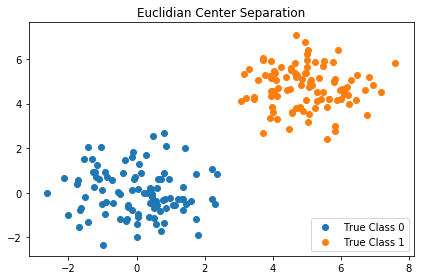

In [24]:

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 1*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 1*np.identity(d)
mean2 = 5*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
#true_labels = true_labels[idx]
#np.random.shuffle(idx)
#data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Euclidian Center Separation')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

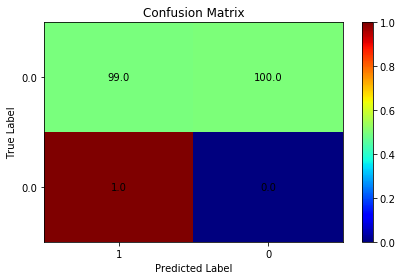

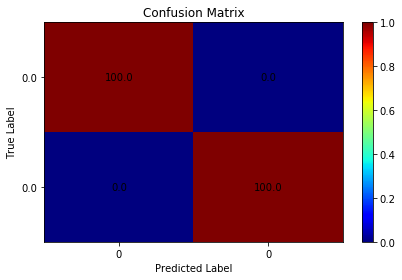

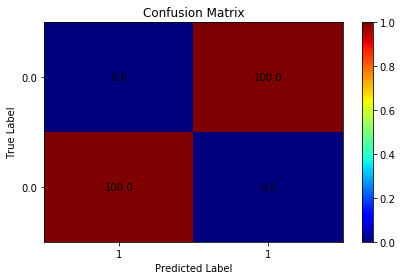

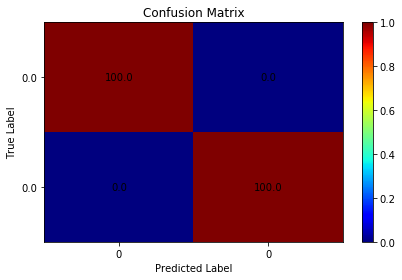

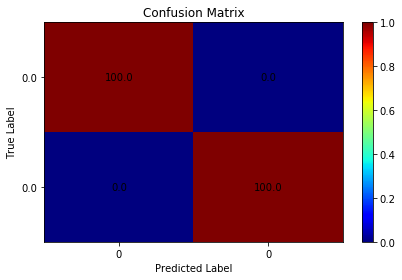

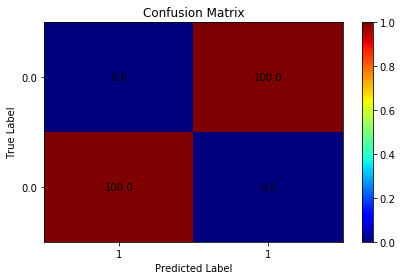

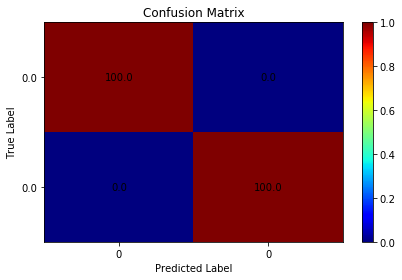

In [25]:
best = parameter_sweep(data, true_labels, 2)

Sigma = 30.0
purity = 1.0


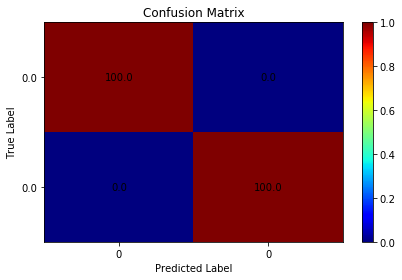

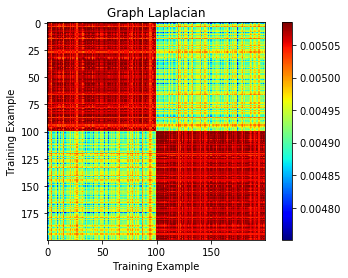

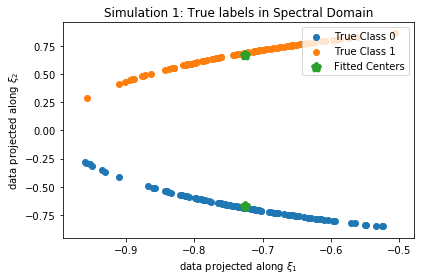

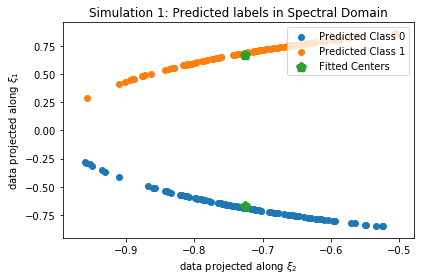

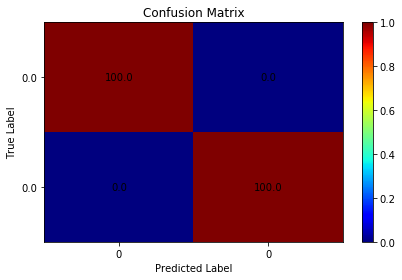

In [26]:
plot_best_2d(data, true_labels, 2, best, title="Simulation 1")

As we can see, the fact that the points are totally separated spatially by their centers leads to the observation that the data points will just sort of "run" along opposite sides of the RBF, and all points can be easily classified due to the radial symmetry of the RBF (since they will be closest to the center on their respective side, and not on the opposite side, for all elements in the class). Note that it sort of looks like we smeared the clusters along perfectly opposite sides of our RBF due to the PCA step that we take. Since the data is separable in its native dimension, we obtain a high $\sigma$ value as we would expect. Also, note that the Laplacian has its highest features in the within-cluster, so when we take a rank-2 approximation given our 2 true clusters we will accurately capture these. 

# Simulation 2: Euclidian Center difference, Less Separation

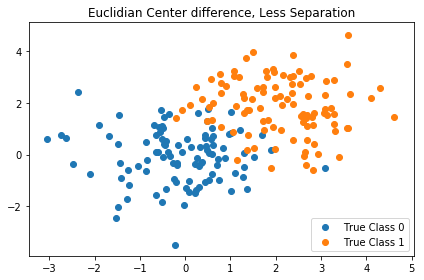

In [27]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from clustering import Kmeans

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 1*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 1*np.identity(d)
mean2 = 2*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
true_labels = true_labels[idx]
#np.random.shuffle(idx)
#data = data[:, idx]
#true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Euclidian Center difference, Less Separation')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

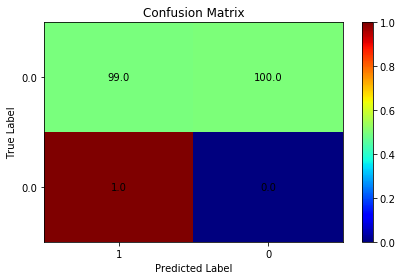

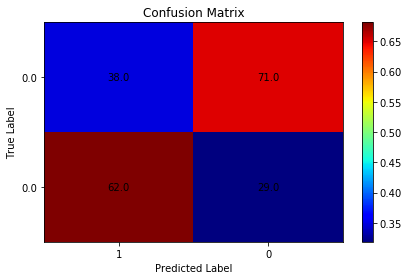

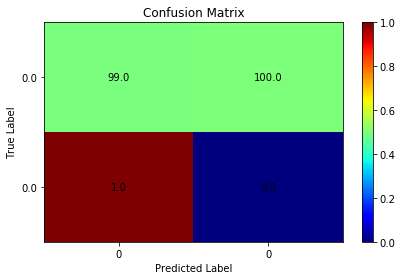

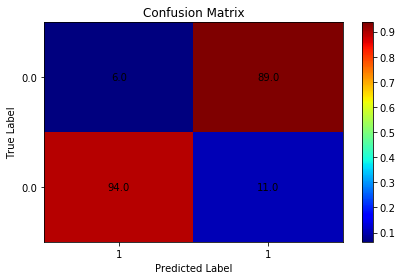

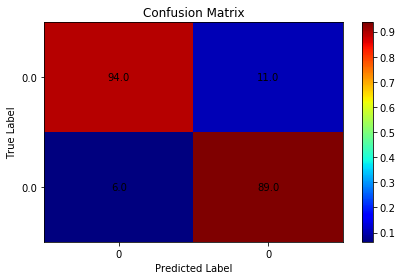

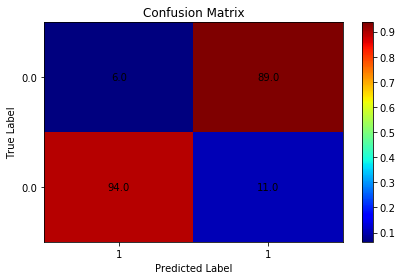

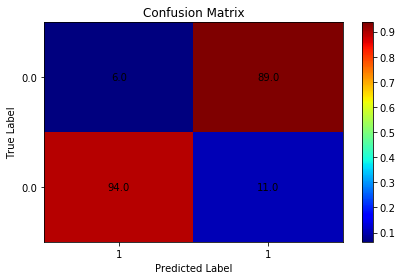

In [28]:
best = parameter_sweep(data, true_labels, 2)

Sigma = 30.0
purity = 0.915


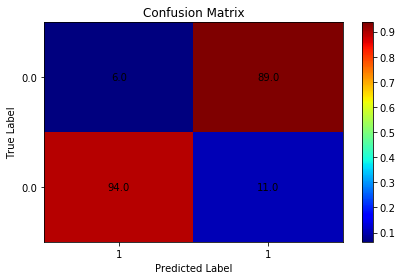

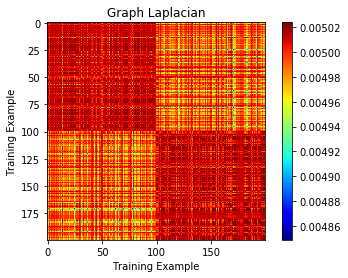

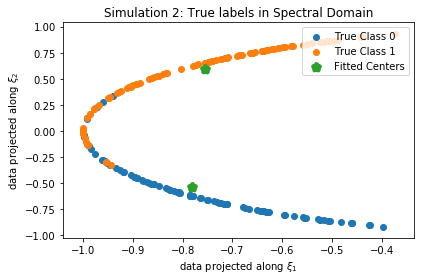

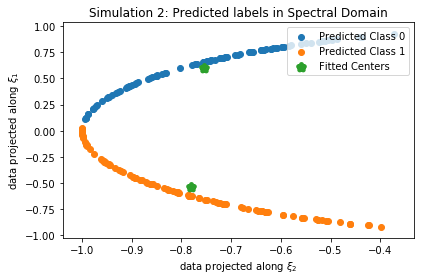

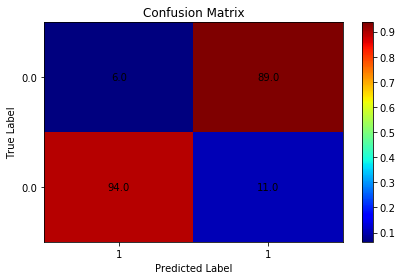

In [29]:
plot_best_2d(data, true_labels, 2, best, title="Simulation 2")

Even though our data is not linearly separable, our RBF is able to "smear" the clusters along the sides of a wide gaussian again and give good classification.

# Simulation 3: Euclidian Center Inseparable Example

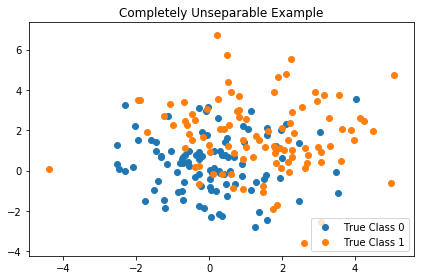

In [30]:

d=2  # 2d data sampled
n=100  # number of points to sample
covar1 = 2*np.identity(d)  # simulated data with I covariance
# simulate n samples of zero-mean, gaussian noise, just like the model
# specifies
data1 = np.random.multivariate_normal(mean=np.zeros((d,)), cov=covar1,
                                      size=n).transpose()
covar2 = 3*np.identity(d)
mean2 = 1.5*np.ones((d,))  # place far away so perfectly separable
data2 = np.random.multivariate_normal(mean=mean2, cov=covar2,
                                      size=n).transpose()
data = np.hstack((data1, data2))
# the true labels are class 0 for first half, and then class 1 for second half
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
# randomly permute the labels
idx = np.array(range(0, len(true_labels)))
#true_labels = true_labels[idx]
#np.random.shuffle(idx)
#data = data[:, idx]
#true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Completely Unseparable Example')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

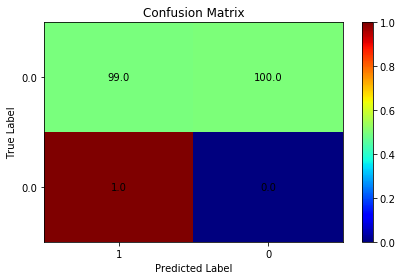

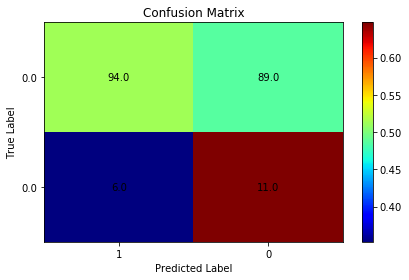

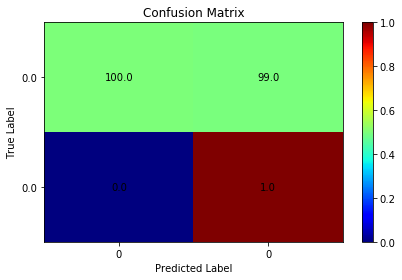

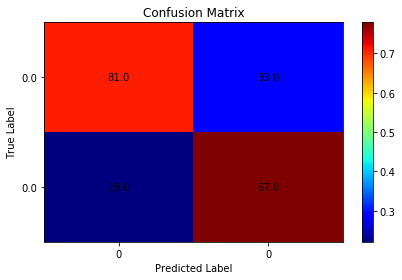

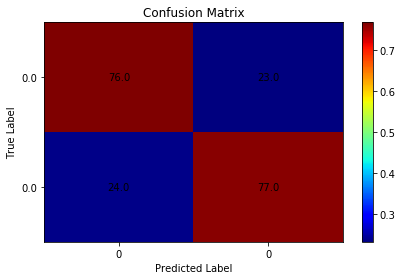

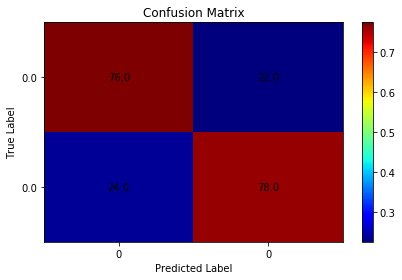

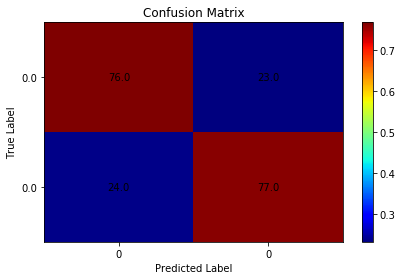

In [31]:
best = parameter_sweep(data, true_labels, 2)

Sigma = 10.0
purity = 0.76


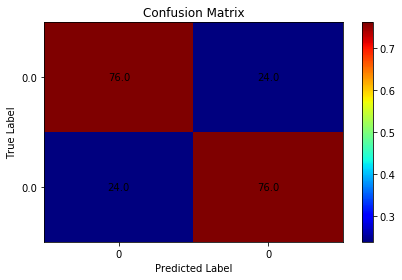

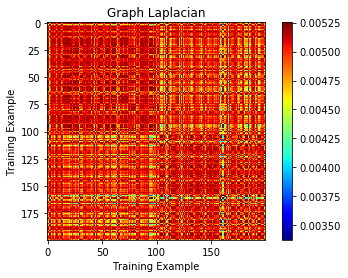

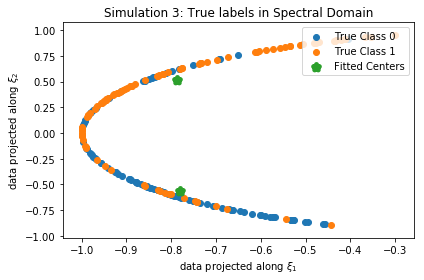

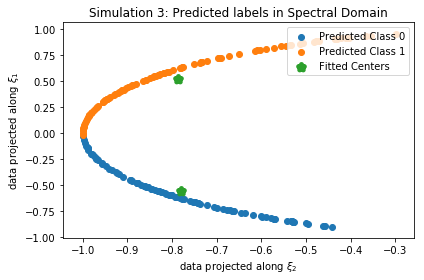

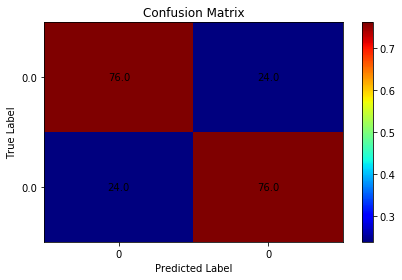

In [32]:
plot_best_2d(data, true_labels, 2, best, title="Simulation 3")

Even when our data is totally inseparable, we can see that we still are able to find a good approximate of the true data centers by again "smearing" our clusters on opposite ends of our RBF through a projection. We can't classify "well" here due to the complete inseparability, but we still get a decent estimate.

# Simulation 4: Multi Class with Linear Separability

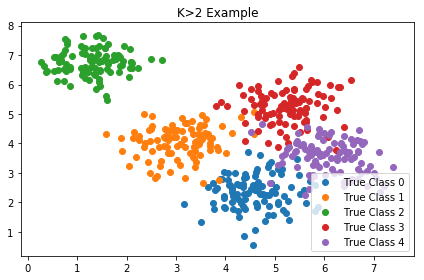

In [33]:

d=2  # 2d data sampled
n=100  # number of points to sample
K=5
xmean = np.random.uniform(low=0, high=7, size=K).tolist()
ymean = np.random.uniform(low=0, high=7, size=K).tolist()
variance = np.array([0.3, 0.3, 0.2, .3, 0.3]).tolist()

data_per_class = []
for i, (x, y, v) in enumerate(zip(xmean, ymean, variance)):
    data_per_class.append(np.random.multivariate_normal(mean = np.array([x, y]),
                                                        cov = v*np.identity(d),
                                                        size=n).transpose())

for i, d in enumerate(data_per_class):
    if i == 0:
        data = data_per_class[i]
        true_labels = i*np.ones((n,))
    else:
        data = np.hstack((data, data_per_class[i]))
        true_labels = np.concatenate((true_labels, i*np.ones((n,))))

idx = np.array(range(0, len(true_labels)))
#np.random.shuffle(idx)
#np.random.shuffle(idx)
#data = data[:, idx]
#true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
label = []
scat = []
for i in range(0, K):
    scat.append(ax.scatter(data[0, true_labels == i],
                           data[1, true_labels == i]))
    label.append('True Class {}'.format(i))

ax.set_title('K>2 Example')
ax.legend(tuple(scat), tuple(label), loc='lower right')
fig.tight_layout()
fig.show()

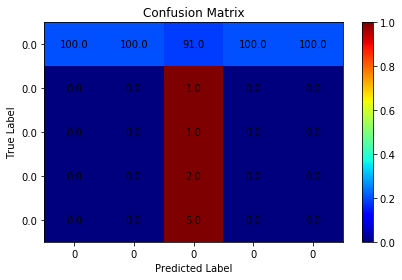

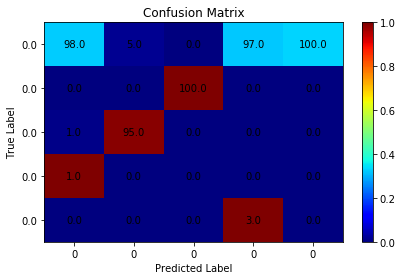

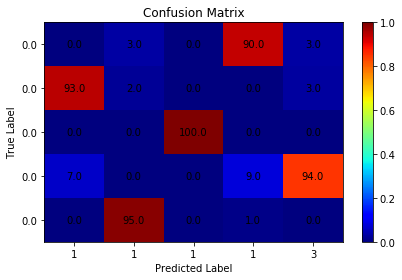

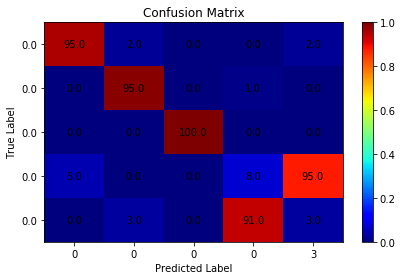

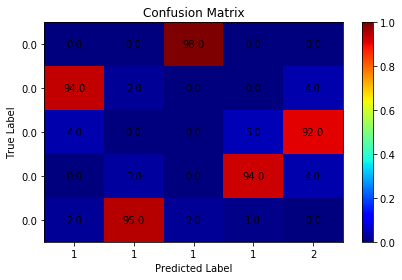

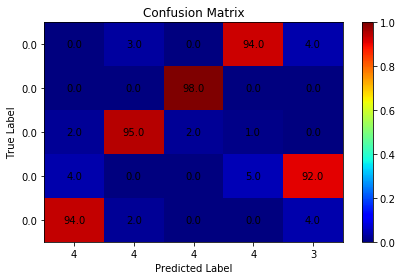

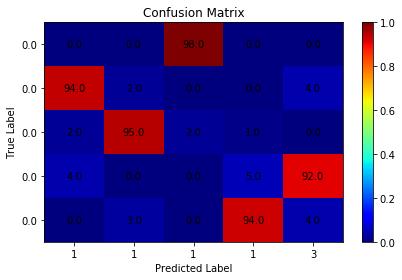

In [34]:
best = parameter_sweep(data, true_labels, 5)

Sigma = 1.0
500
500
purity = 0.95


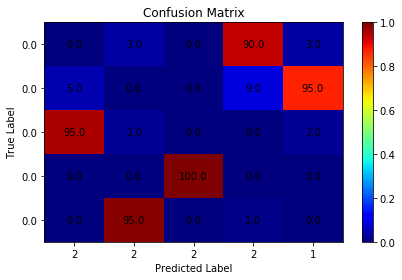

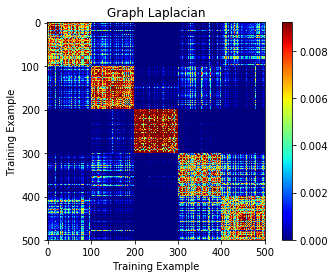

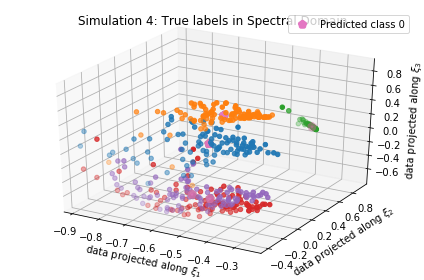

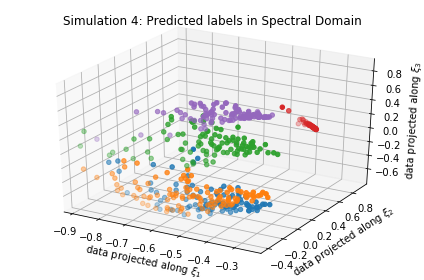

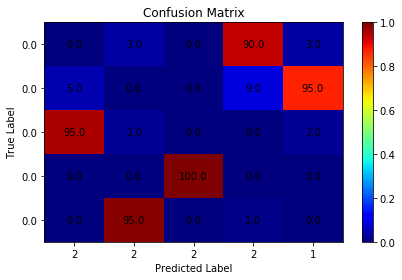

In [35]:
plot_best_3d(data, true_labels, 5, best, title="Simulation 4")

Notice that our points here retain their spatial differences in our spectral domain. We can see from the Laplacian that we have $5$ notable components, and even wtih just $3$ of $5$ components shown we still can visually see the separation between different classes. We obtain high accuracy given our relatively flat gamma, indicating that much of our separation can be retained in the native space, but moving to the spectral domain still affords us some benefits.

# Simulation 5: Radial Difference, K=2

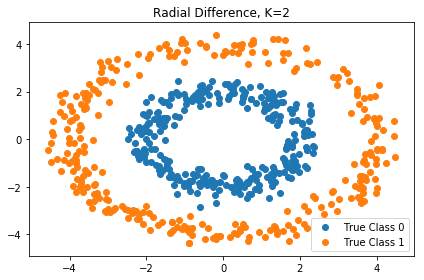

In [14]:

n=300
dim=2
s=0.3
data1 = sample_ball(r=2, dim=dim, n=n, s=s)
data2 = sample_ball(r=4, dim=dim, n=n, s=s)
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
data = np.hstack((data1, data2))
idx = range(0, len(true_labels))
#np.random.shuffle(idx)
# randomly permute
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Radial Difference, K=2')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

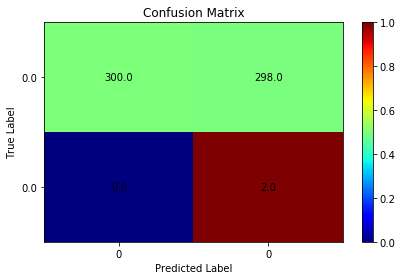

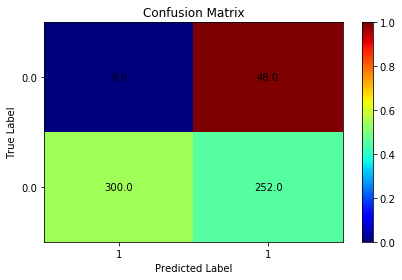

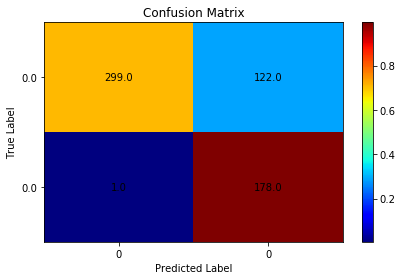

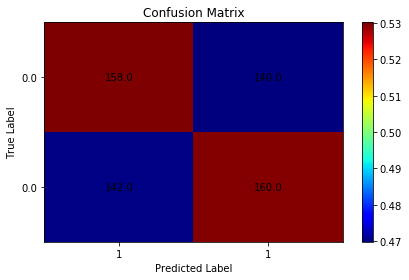

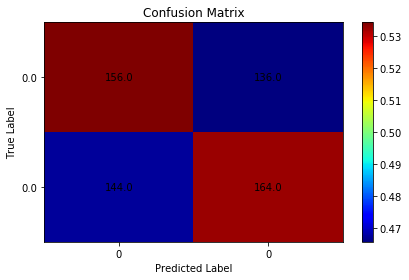

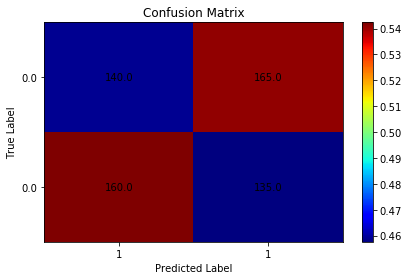

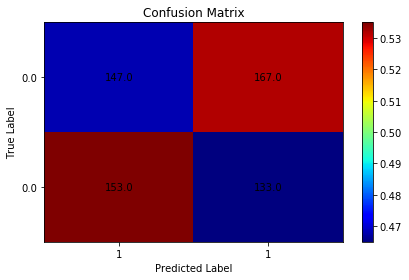

In [15]:
best = parameter_sweep(data, true_labels, 2)

Sigma = 0.5
purity = 0.795


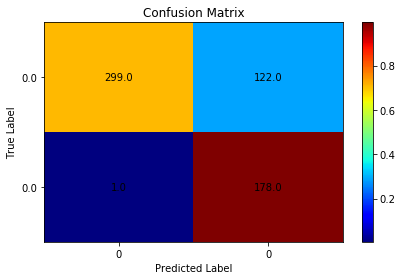

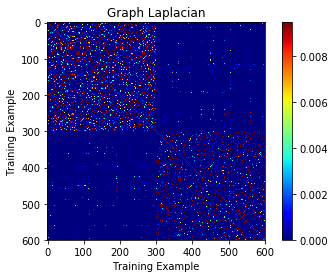

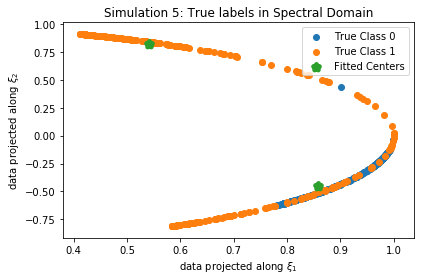

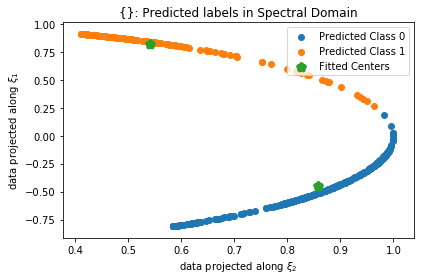

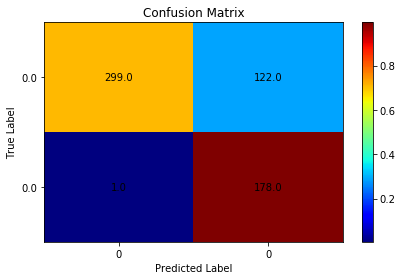

In [16]:
plot_best_2d(data, true_labels, 2, best, title="Simulation 5")

Here, due to our graph's radial clustering, we can see that we will favor a narrow $\sigma$ due to the afformentioned reasons. With our narrow $\sigma$, the values of our laplacian are very small, and we can see that our clusters end up incredibly tight. We can perfectly cluster this radially symmetric dataset.

# Simulation 6: Radial Difference, K=3

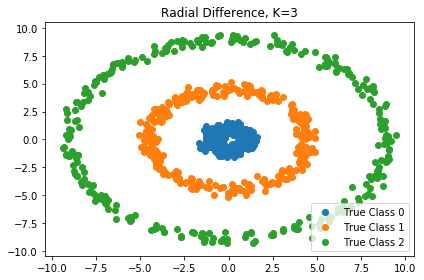

In [17]:
n=300
dim=2
s=0.3
data1 = sample_ball(r=1, dim=dim, n=n, s=s)
data2 = sample_ball(r=4.5, dim=dim, n=n, s=s)
data3 = sample_ball(r=9, dim=dim, n=n, s=s)
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,)),
                              2*np.ones((n,))))
data = np.hstack((data1, data2, data3))
idx = range(0, len(true_labels))
np.random.shuffle(idx)
#randomly permute
#data = data[:, idx]
#true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
scat3 = ax.scatter(data[0, true_labels == 2], data[1, true_labels == 2])
ax.set_title('Radial Difference, K=3')
ax.legend((scat1, scat2, scat3), ('True Class 0', 'True Class 1', 'True Class 2'),
          loc='lower right')
fig.tight_layout()
fig.show()

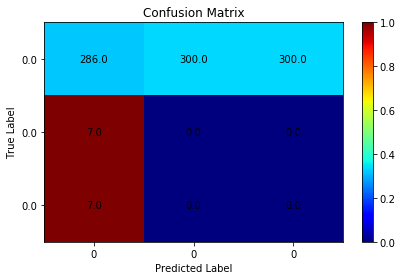

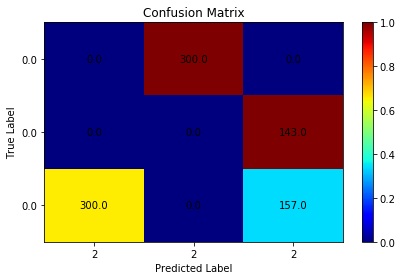

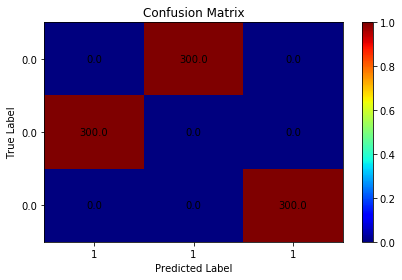

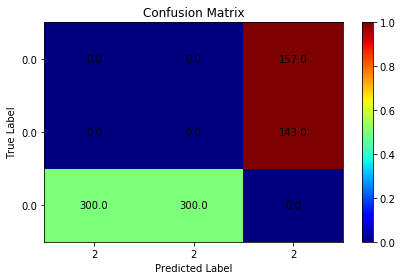

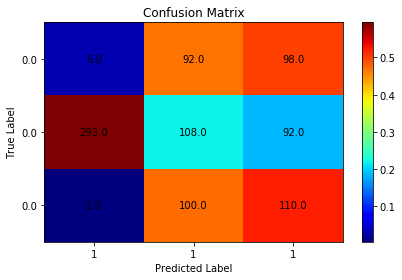

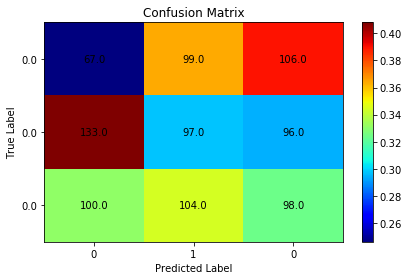

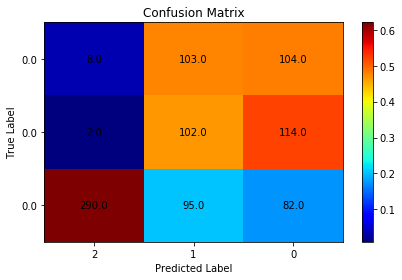

In [18]:
best = parameter_sweep(data, true_labels, 3)

Sigma = 0.5
900
900
purity = 1.0


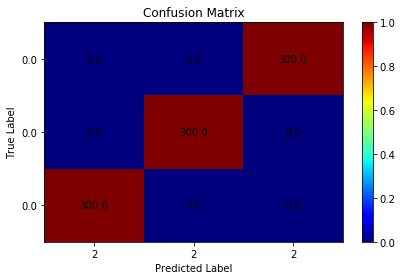

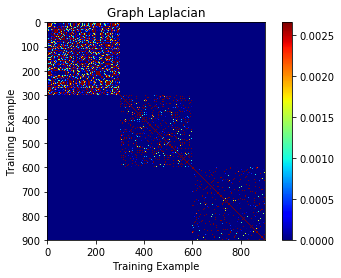

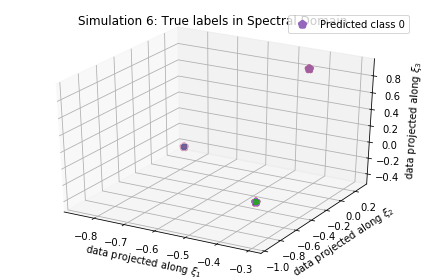

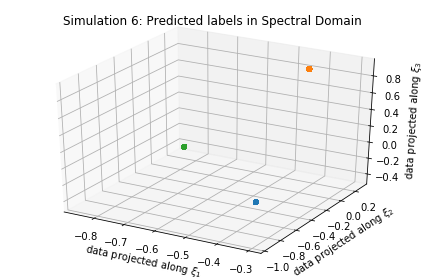

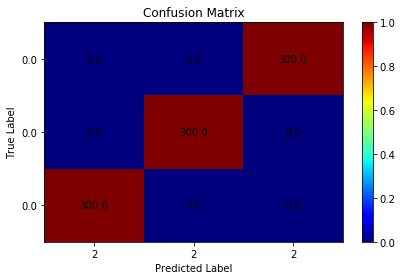

In [19]:
plot_best_3d(data, true_labels, 3, best, title="Simulation 6")

Like before, the radial symmetry allows us to project our data effectively onto a RBF, giving us fantastic classification accuracy.

# Simulation 7: Non-Concentric Spheres

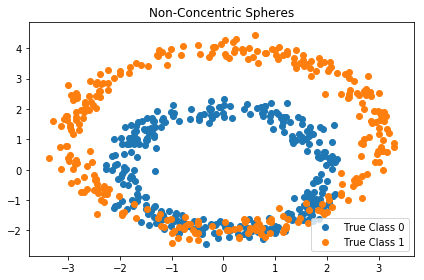

In [20]:
n=300
dim=2
s=0.2
data1 = sample_ball(r=2, dim=dim, n=n, s=s)
new_mean = np.identity(dim)
new_mean[0] = 0
data2 = sample_ball(r=3, dim=dim, n=n, s=s) + new_mean.dot(np.ones((dim, n)))
true_labels = np.concatenate((0*np.ones((n,)), 1*np.ones((n,))))
data = np.hstack((data1, data2))
idx = range(0, len(true_labels))
#np.random.shuffle(idx)
# randomly permute
data = data[:, idx]
true_labels = true_labels[idx]

# visualize
fig = plt.figure()
ax = fig.add_subplot(111)
scat1 = ax.scatter(data[0, true_labels == 0], data[1, true_labels == 0])
scat2 = ax.scatter(data[0, true_labels == 1], data[1, true_labels == 1])
ax.set_title('Non-Concentric Spheres')
ax.legend((scat1, scat2), ('True Class 0', 'True Class 1'), loc='lower right')
fig.tight_layout()
fig.show()

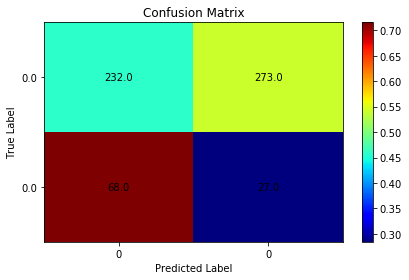

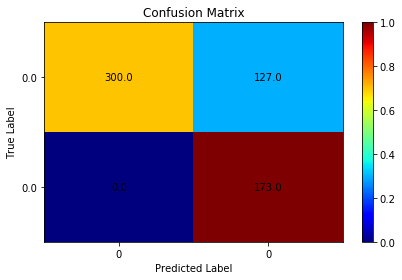

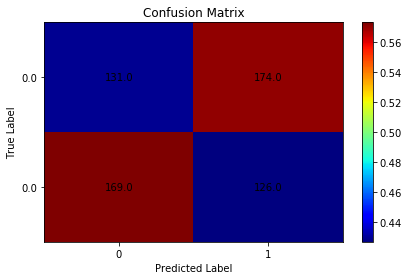

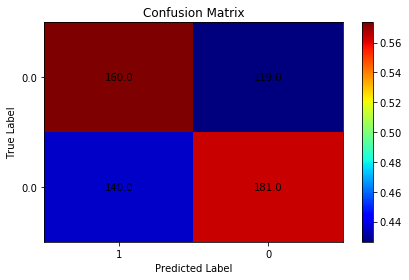

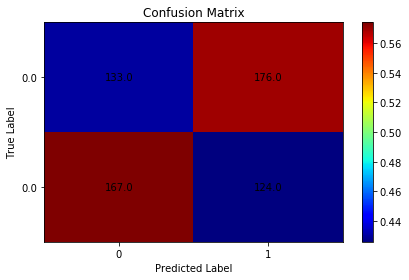

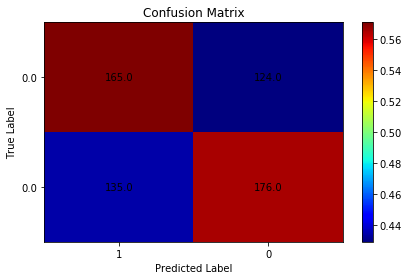

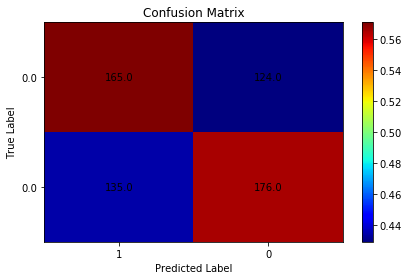

In [21]:
best = parameter_sweep(data, true_labels, 2)

Sigma = 0.1
purity = 0.788333333333


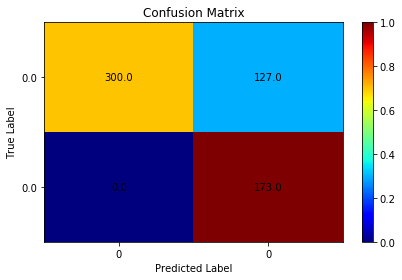

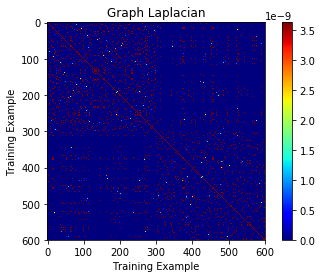

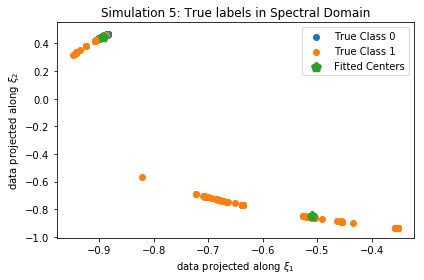

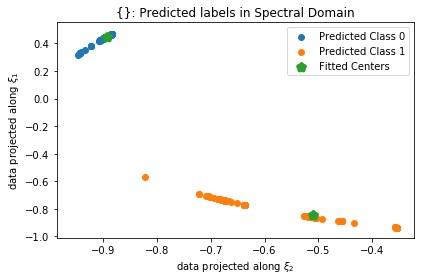

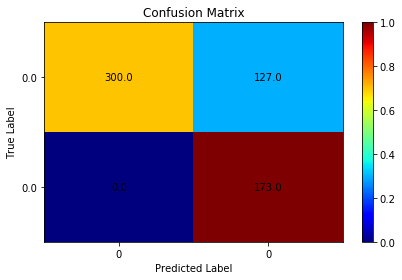

In [22]:
 plot_best_2d(data, true_labels, 2, best, title="Simulation 5")

We can see that we manage to classify some of the points decently, particularly, the top of the Gaussian (the analogue of the orange outer ring), but we fail to accurately differentiate the blue from the bottom ring of hte orange due to their overlap. No projection onto any gaussian could get this classification right, but we do a not-too-bad job.

# Take Aways:

Spectral clustering is, essentially, a regular classification algorithm with added benefits, not restrictions, when tuned for $\sigma$ properly. We can either classify in the native space using a large $\sigma$, or we have the added flexibility of being able to significantly reshape the space into an RBF if necessary to obtain good accuracy. Traditional algorithms like standard $K-$means do not have this ability.